<a href="https://colab.research.google.com/github/michalgorul/classification-of-musical-genres/blob/main/GTZAN_MG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
# !pip install tensorflow==2.10.0 pandas==1.5.0 numpy==1.23.3 seaborn==0.12.0 scikit-learn==1.1.2 librosa==0.9.2 imageio==2.22.3
!pip install pydub==0.25.1
!pip install mlxtend==0.21.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.8 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [3]:
import os
import random
import imageio
import librosa
import librosa.display
import shutil
import glob
import numpy as np

from typing import Tuple, Dict, List, Optional
from matplotlib import pyplot as plt
from PIL import ImageFile
from keras import models, layers, activations, optimizers, losses, metrics, Sequential, regularizers
from keras.layers import Flatten
from mlxtend.plotting import plot_confusion_matrix

# Global variables

In [4]:
genres = [
            "blues",
            "classical",
            "country",
            "disco",
            "hiphop",
            "jazz",
            "metal",
            "pop",
            "reggae",
            "rock",
        ]

gtzan_wavs = "/content/drive/MyDrive/GTZAN/wavs"
gtzan_spectograms = "/content/drive/MyDrive/GTZAN/spectograms"

gtzan_train_dir = "/content/drive/MyDrive/GTZAN/train"
gtzan_val_dir = "/content/drive/MyDrive/GTZAN/validation"
gtzan_test_dir = "/content/drive/MyDrive/GTZAN/test"

directories: Dict[str, str] = {
    "train_dir": gtzan_train_dir,
    "val_dir": gtzan_val_dir,
    "test_dir": gtzan_test_dir,
}

image_target_size = (288, 432)

# Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Random spectogram

In [ ]:
def get_path_name_file(file_path: Optional[str], dir: str = "spectograms") -> Tuple[str, str]:
  selected_dir = gtzan_spectograms if dir == "spectograms" else gtzan_wavs
  if not file_path:
    directory_name = random.choice(os.listdir(selected_dir))
    file_name = random.choice(
        os.listdir(selected_dir + "/" + directory_name)
    )
    file_path = f"{selected_dir}/{directory_name}/{file_name}"
    return file_path, file_name
  return file_path, file_path.split("\\")[-1]

file_path, file_name = get_path_name_file(file_path=None)

print(f"Random spectogram file path: \n\t{file_path}\n")
print(f"Random spectogram file name: \n\t{file_name}\n")

Random spectogram file path: 
	/content/drive/MyDrive/GTZAN/spectograms/pop/pop00004.png

Random spectogram file name: 
	pop00004.png



Image dimensions: 
	(288, 432, 4)


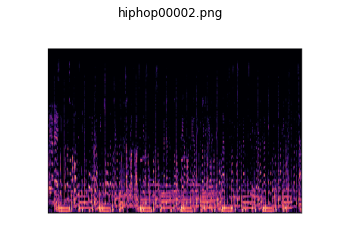

In [ ]:
def show_spectogram_from_dataset(file_path: Optional[str]) -> None:
  file_path, file_name = get_path_name_file(file_path=file_path)
  img = imageio.imread(file_path)
  print(f"Image dimensions: \n\t{img.shape}")

  plt.imshow(img)
  plt.title(file_name)
  plt.axis("off")
  plt.show()
  return

show_spectogram_from_dataset(file_path=None)

## Decibel spectogram from wav file

Shape of d object: (1025, 1293)


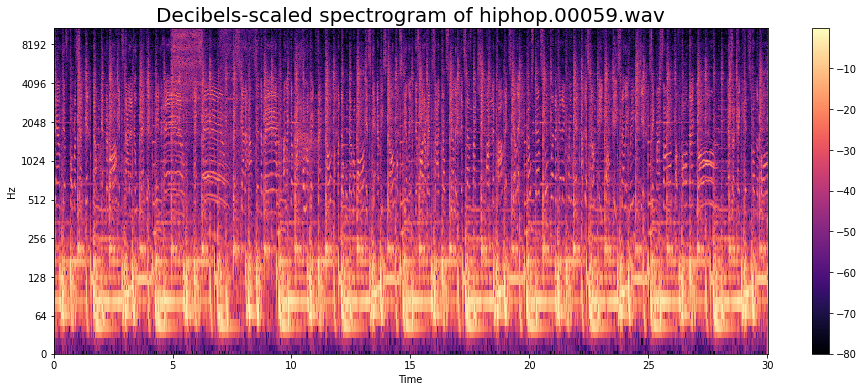

In [ ]:
def create_decibel_spectogram_from_wav_file(sound_file_path: Optional[str]) -> None:
  wav_file_path, wav_file_name = get_path_name_file(file_path=sound_file_path, dir="wavs")
  y, sample_rate = librosa.load(wav_file_path)

  # Short-time Fourier transform (STFT).
  d = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
  print("Shape of d object:", np.shape(d))
  
  # Convert amplitude spectrogram to Decibels-scaled spectrogram.
  decibels = librosa.amplitude_to_db(d, ref=np.max)
  
  # Creating the spectogram.
  plt.figure(figsize=(16, 6))
  librosa.display.specshow(
      decibels, sr=sample_rate, hop_length=512, x_axis="time", y_axis="log"
  )
  plt.colorbar()
  plt.title(f"Decibels-scaled spectrogram of {wav_file_name}", fontsize=20)
  plt.show()
  return

create_decibel_spectogram_from_wav_file(sound_file_path=None)

## Mel spectogram from wav file

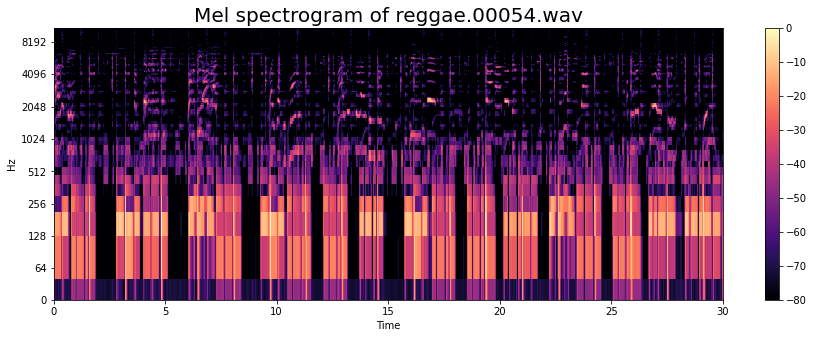

In [ ]:
def create_mel_spectogram_from_sound_file(sound_file_path: Optional[str]) -> None:
  wav_file_path, wav_file_name = get_path_name_file(file_path=sound_file_path, dir="wavs")
  y, sample_rate = librosa.load(wav_file_path)

  s = librosa.feature.melspectrogram(y=y, sr=sample_rate)
  decibels = librosa.amplitude_to_db(s, ref=np.max)
  plt.figure(figsize=(15, 5))
  librosa.display.specshow(
      decibels, sr=sample_rate, hop_length=512, x_axis="time", y_axis="log"
  )
  plt.colorbar()
  plt.title(f"Mel spectrogram of {wav_file_name}", fontsize=20)
  plt.show()
  return

create_mel_spectogram_from_sound_file(sound_file_path=None)

# Data initialization

### Utils

In [5]:
def copy_files(file_paths: List[str], dest_dir: str) -> None:
  try:
    for file in file_paths:
        shutil.copy(
            file,
            os.path.join(
                os.path.join(dest_dir),
                os.path.split(file)[1],
            ),
        )
  except KeyError as e:
      print(f"Failed to copy files to destination directory, error={e}")


def create_directories(directories: Dict[str, str]) -> None:
  # Create folders
  for folder_name, path in directories.items():
    if os.path.exists(path):
      shutil.rmtree(path)
      os.mkdir(path)
    else:
      os.mkdir(path)

def create_directory(path: str) -> None:
  # Create folder
  if os.path.exists(path):
    shutil.rmtree(path)
    os.mkdir(path)
  else:
    os.mkdir(path)
  
def remove_directories(directories: Dict[str, str]) -> None:
  # Remove folders
  for folder_name, path in directories.items():
    if os.path.exists(path):
      shutil.rmtree(path)

### Init data with existing spectograms

In [6]:
def data_init_10sec_from_dataset() -> None:

  create_directories(directories)

  images_path = gtzan_spectograms
  genres = list(os.listdir(images_path))

  print("Genres:", genres)

  for genre in genres:
    print(f"\nCurrent genre: {genre}")

    # Finding all images & split in train, test, and validation
    src_file_paths = []

    for im in glob.glob(os.path.join(images_path, f"{genre}", "*.png"), recursive=True):
        src_file_paths.append(im)

    # Randomizing directories content
    random.shuffle(src_file_paths)

    files_len = len(src_file_paths)

    test_files = src_file_paths[0:int(files_len * 0.05)]
    val_files = src_file_paths[int(files_len * 0.05):int(files_len * 0.15)]
    train_files = src_file_paths[int(files_len * 0.15):]

    print("Number of test files:",len(test_files))
    print("Number of validation files:",len(val_files))
    print("Number of train files:",len(train_files))

    #  make destination folders for train and test images
    for folder_name, path in directories.items():
        if not os.path.exists(path + f"/{genre}"):
            os.mkdir(f"{path}/{genre}")

    # Coping training and testing images over
    copy_files(
        file_paths=train_files, dest_dir=f"{directories['train_dir']}/{genre}/"
    )
    copy_files(
        file_paths=test_files, dest_dir=f"{directories['test_dir']}/{genre}/"
    )
    copy_files(file_paths=val_files, dest_dir=f"{directories['val_dir']}/{genre}/")

data_init_10sec_from_dataset()

Genres: ['disco', 'rock', 'hiphop', 'pop', 'blues', 'metal', 'jazz', 'classical', 'reggae', 'country']

Current genre: disco
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: rock
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: hiphop
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: pop
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: blues
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: metal
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: jazz
Number of test files: 4
Number of validation files: 10
Number of train files: 85

Current genre: classical
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: reggae
Number of test files: 5
Number of validation file

### Divide the songs into test, train and val dirs 

In [ ]:
gtzan_train_temp_dir = "/content/drive/MyDrive/GTZAN/train_temp"
gtzan_val_temp_dir = "/content/drive/MyDrive/GTZAN/validation_temp"
gtzan_test_temp_dir = "/content/drive/MyDrive/GTZAN/test_temp"

gtzan_train_temp_dir_3sec = "/content/drive/MyDrive/GTZAN/train_temp_3sec"
gtzan_val_temp_dir_3sec = "/content/drive/MyDrive/GTZAN/validation_temp_3sec"
gtzan_test_temp_dir_3sec = "/content/drive/MyDrive/GTZAN/test_temp_3sec"

wavs_directories_temp: Dict[str, str] = {
    "train_dir": gtzan_train_temp_dir,
    "val_dir": gtzan_val_temp_dir,
    "test_dir": gtzan_test_temp_dir,
}

wavs_directories_temp_3sec: Dict[str, str] = {
    "train_dir": gtzan_train_temp_dir_3sec,
    "val_dir": gtzan_val_temp_dir_3sec,
    "test_dir": gtzan_test_temp_dir_3sec,
}

In [ ]:
def devide_songs() -> None:
  create_directories(wavs_directories_temp)

  songs_path = gtzan_wavs
  genres = list(os.listdir(songs_path))
  
  print("Genres:", genres)

  for genre in genres:
    print(f"\nCurrent genre: {genre}")

    # Finding all wavs & split in train, test, and validation
    src_file_paths = []

    for im in glob.glob(os.path.join(songs_path, f"{genre}", "*.wav"), recursive=True):
        src_file_paths.append(im)

    # Randomizing directories content
    random.shuffle(src_file_paths)

    files_len = len(src_file_paths)

    test_files = src_file_paths[0:int(files_len * 0.05)]
    val_files = src_file_paths[int(files_len * 0.05):int(files_len * 0.15)]
    train_files = src_file_paths[int(files_len * 0.15):]

    print("Number of test files:",len(test_files))
    print("Number of validation files:",len(val_files))
    print("Number of train files:",len(train_files))

    #  make destination folders for train and test images
    for folder_name, path in wavs_directories_temp.items():
        if not os.path.exists(path + f"/{genre}"):
            os.mkdir(f"{path}/{genre}")

    # Coping training and testing images over
    copy_files(
        file_paths=train_files, dest_dir=f"{wavs_directories_temp['train_dir']}/{genre}/"
    )
    copy_files(
        file_paths=test_files, dest_dir=f"{wavs_directories_temp['test_dir']}/{genre}/"
    )
    copy_files(file_paths=val_files, dest_dir=f"{wavs_directories_temp['val_dir']}/{genre}/")


devide_songs()

Genres: ['rock', 'pop', 'reggae', 'hiphop', 'country', 'blues', 'classical', 'metal', 'disco', 'jazz']

Current genre: rock
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: pop
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: reggae
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: hiphop
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: country
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: blues
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: classical
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: metal
Number of test files: 5
Number of validation files: 10
Number of train files: 85

Current genre: disco
Number of test files: 5
Number of validation f

In [ ]:
from pydub import AudioSegment

def make_3_sec_wavs(wavs_path: str, dest_path: str) -> None:
  # create_directories(wavs_directories_temp_3sec)
  create_directory(dest_path)
  genres = list(os.listdir(wavs_path))
  i = 0
  for genre in genres:
    print(f"\tCurrent genre: {genre}")
    # Finding all wavs & create 3sec songs
    src_file_paths = []

    for im in glob.glob(os.path.join(wavs_path, f"{genre}", "*.wav"), recursive=True):
      src_file_paths.append(im)
    j = 0
    for song in src_file_paths:
      j = j + 1
      for w in range(0, 10):
        try:
          i = i + 1
          t1 = 3 * w * 1000
          t2 = 3 * (w + 1) * 1000
          new_audio = AudioSegment.from_wav(song)
          new = new_audio[t1:t2]

          genre_dir_path = f"{dest_path}/{genre}/"
          
          if not os.path.exists(genre_dir_path):
              os.mkdir(genre_dir_path)

          file_name = genre + str(j) + str(w)

          new.export(
              f"{genre_dir_path}/{file_name}.wav",
              format="wav",
          )
        except Exception as e:
          print(e)

In [ ]:
print("Creating train files:")
make_3_sec_wavs(gtzan_train_temp_dir, gtzan_train_temp_dir_3sec)

Creating train files:
	Current genre: rock
	Current genre: pop
	Current genre: reggae
	Current genre: hiphop
	Current genre: country
	Current genre: blues
	Current genre: classical
	Current genre: metal
	Current genre: disco
	Current genre: jazz


In [ ]:
print("\nCreating validation files:")
make_3_sec_wavs(gtzan_val_temp_dir, gtzan_val_temp_dir_3sec)


Creating validation files:
	Current genre: rock
	Current genre: pop
	Current genre: reggae
	Current genre: hiphop
	Current genre: country
	Current genre: blues
	Current genre: classical
	Current genre: metal
	Current genre: disco
	Current genre: jazz


In [ ]:
print("\nCreating test files:")
make_3_sec_wavs(gtzan_test_temp_dir, gtzan_test_temp_dir_3sec)


Creating test files:
	Current genre: rock
	Current genre: pop
	Current genre: reggae
	Current genre: hiphop
	Current genre: country
	Current genre: blues
	Current genre: classical
	Current genre: metal
	Current genre: disco
	Current genre: jazz


In [ ]:
from matplotlib.pyplot import figure

def make_3_sec_images(genre: str, songs_path: str, images_path: str, last_song: int = 0) -> None:
  g = genre
  j = 0
  for filename in os.listdir(os.path.join(songs_path, f"{g}")):
    j = j + 1
    if j > last_song:
      if not j % 10:
        print(f"Current file in {g}: {j}")

      song = os.path.join(f"{songs_path}/{g}", f"{filename}")

      y, sr = librosa.load(song)
      mels = librosa.feature.melspectrogram(y=y, sr=sr)
      figure(figsize=(4, 2))
      plt.imshow(librosa.power_to_db(mels, ref=np.max), aspect="auto")
      plt.axis("off")

      genre_dir_path = f"{images_path}/{g}"
      if not os.path.exists(genre_dir_path):
          os.mkdir(genre_dir_path)

      plt.savefig(f"{genre_dir_path}/{g + str(j)}.png")
      plt.close()


create_directories(directories)
for genre in genres:
  # make_3_sec_images(genre, gtzan_train_temp_dir_3sec, gtzan_train_dir)
  # make_3_sec_images(genre, gtzan_val_temp_dir_3sec, gtzan_val_dir)
  make_3_sec_images(genre, gtzan_test_temp_dir_3sec, gtzan_test_dir)

Current file in blues: 10
Current file in blues: 20
Current file in blues: 30
Current file in blues: 40
Current file in blues: 50
Current file in classical: 10
Current file in classical: 20
Current file in classical: 30
Current file in classical: 40
Current file in classical: 50
Current file in country: 10
Current file in country: 20
Current file in country: 30
Current file in country: 40
Current file in country: 50
Current file in disco: 10
Current file in disco: 20
Current file in disco: 30
Current file in disco: 40
Current file in disco: 50
Current file in hiphop: 10
Current file in hiphop: 20
Current file in hiphop: 30
Current file in hiphop: 40
Current file in hiphop: 50
Current file in jazz: 10
Current file in jazz: 20
Current file in jazz: 30
Current file in jazz: 40
Current file in metal: 10
Current file in metal: 20
Current file in metal: 30
Current file in metal: 40
Current file in metal: 50
Current file in pop: 10
Current file in pop: 20
Current file in pop: 30
Current file 

In [ ]:
remove_directories(wavs_directories_temp)
remove_directories(wavs_directories_temp_3sec)

NameError: ignored

### Sanity data test

In [7]:
def sanity_data_test() -> None:
  print(
    "Genres directories in train data:",
    len(os.listdir(directories["train_dir"])),
  )
  print(
    "Genres directories in test data:", len(os.listdir(directories["test_dir"]))
  )
  print(
    "Genres directories in validation data:",
    len(os.listdir(directories["val_dir"])),
  )

  print("\nTotal number of images in:")
  for genre in genres:
    print()
    for folder_name, path in directories.items():
      print(
        f"\t{folder_name} of {genre} songs: "
        + str(len(os.listdir(f"{directories[folder_name]}/{genre}"))),
      )

sanity_data_test()

Genres directories in train data: 10
Genres directories in test data: 10
Genres directories in validation data: 10

Total number of images in:

	train_dir of blues songs: 85
	val_dir of blues songs: 10
	test_dir of blues songs: 5

	train_dir of classical songs: 85
	val_dir of classical songs: 10
	test_dir of classical songs: 5

	train_dir of country songs: 85
	val_dir of country songs: 10
	test_dir of country songs: 5

	train_dir of disco songs: 85
	val_dir of disco songs: 10
	test_dir of disco songs: 5

	train_dir of hiphop songs: 85
	val_dir of hiphop songs: 10
	test_dir of hiphop songs: 5

	train_dir of jazz songs: 85
	val_dir of jazz songs: 10
	test_dir of jazz songs: 4

	train_dir of metal songs: 85
	val_dir of metal songs: 10
	test_dir of metal songs: 5

	train_dir of pop songs: 85
	val_dir of pop songs: 10
	test_dir of pop songs: 5

	train_dir of reggae songs: 85
	val_dir of reggae songs: 10
	test_dir of reggae songs: 5

	train_dir of rock songs: 85
	val_dir of rock songs: 10
	t

# Networks

## Necessary for all

### Copy files to Colab instance

In [43]:
train_dir_on_colab_instance = "/content/bin/data/train"
val_dir_on_colab_instance = "/content/bin/data/val"

if os.path.exists(train_dir_on_colab_instance):
  shutil.rmtree(train_dir_on_colab_instance)

if os.path.exists(val_dir_on_colab_instance):
  shutil.rmtree(val_dir_on_colab_instance)

shutil.copytree(gtzan_train_dir, train_dir_on_colab_instance)
shutil.copytree(gtzan_val_dir, val_dir_on_colab_instance)

'/content/bin/data/val'

### Plotting functions

In [44]:
def show_training_and_validation_loss(
    epochs: range, loss_values: List[float], val_loss_values: List[float]
) -> None:
  plt.plot(epochs, loss_values, "bo", label="Training loss")
  plt.plot(epochs, val_loss_values, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()


def show_training_and_validation_accuracy(
    epochs: range, acc: List[float], val_acc: List[float]
) -> None:
  plt.plot(epochs, acc, "bo", label="Training acc")
  plt.plot(epochs, val_acc, "b", label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

### Common fit and evaluate function

In [45]:
def fit_model(model, x, y, train_steps, epochs, validation_data, validation_steps, model_path):
  history = model.fit(
        x=x,
        y=y,
        steps_per_epoch=train_steps,
        epochs=EPOCHS,
        validation_data=val_data,
        validation_steps=val_steps,
    )

  try:
    model.save(model_path)
    print(f"Model saved at {model_path}")
  except Exception as e:
    print(f"Failed to save model, error={e}")


  train_loss_values = history.history.get("loss")
  val_loss_values = history.history.get("val_loss")
  train_accuracy = history.history.get("categorical_accuracy")
  val_accuracy = history.history.get("val_categorical_accuracy")
  num_of_epochs = range(1, len(train_accuracy) + 1)

  show_training_and_validation_loss(
      epochs=num_of_epochs, loss_values=train_loss_values, val_loss_values=val_loss_values
  )

  show_training_and_validation_accuracy(
      epochs=num_of_epochs, acc=train_accuracy, val_acc=val_accuracy
  )

def evaluate_model(model, train_x, train_y, val_x, val_y):
  train_score = model.evaluate(
      x=train_x, 
      y=train_y, 
      verbose=0
  )

  print('Train loss:', round(train_score[0], 4))
  print('Train accuracy:', round(train_score[1], 4))

  val_score = model.evaluate(
      x=val_x, 
      y=val_y, 
      verbose=0
  )

  print('Validation loss:', round(val_score[0], 4))
  print('Validation accuracy:', round(val_score[1], 4))

### Test directory initialization

In [46]:
# make test folder with one class

def init_test_dir(test_directory: str) -> None:
  test_dir = test_directory + "/images/"
  try:
    if not os.path.exists(test_dir):
      create_directory(test_dir)
      print("Created 'images' folder")
    else:
      print("'images' folder already exists")
      return

    for genre in genres:
      source = gtzan_test_dir + "/" + genre + "/"

      # code to move the files from sub-folder to main folder.
      files = os.listdir(source)
      for file in files:
          file_name = os.path.join(source, file)
          shutil.move(file_name, test_dir)
      
      os.rmdir(source)
      print(f"\tFiles from {genre} moved")

    print("Initialized Test directory successfuly")
  except Exception as e:
    print(f"Failed initializing test directory, error={e}")
    raise

init_test_dir(gtzan_test_dir)

'images' folder already exists


## My network

### Data generators

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

# MY_NETWORK_BATCH_SIZE = 128
MY_NETWORK_BATCH_SIZE = 20


def get_train_data_generator() -> DirectoryIterator:
  print("Creating train data generator")
  train_datagen = ImageDataGenerator(rescale=1.0 / 255)

  train_dir = train_dir_on_colab_instance
  target_size = image_target_size

  train_generator = train_datagen.flow_from_directory(
      train_dir, 
      target_size=target_size, 
      batch_size=MY_NETWORK_BATCH_SIZE, 
      class_mode="categorical", 
      color_mode="rgba"
  )
  return train_generator


def get_validation_data_generator() -> DirectoryIterator:
  print("Creating validation data generator")
  validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

  validation_dir = val_dir_on_colab_instance
  target_size = image_target_size

  validation_generator = validation_datagen.flow_from_directory(
      validation_dir, 
      target_size=target_size, 
      batch_size=MY_NETWORK_BATCH_SIZE, 
      class_mode="categorical",  
      color_mode="rgba"
  )
  return validation_generator


def list_output_of_generators() -> None:
  for data_batch, labels_batch in get_train_data_generator():
    print("Train generator:")
    print("\tData batch shape:", data_batch.shape)
    print("\tLabels batch shape:", labels_batch.shape)
    print()
    break

  for data_batch, labels_batch in get_validation_data_generator():
    print("Validation generator:")
    print("\tData batch shape:", data_batch.shape)
    print("\tLabels batch shape:", labels_batch.shape)
    break

### Model

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True


def build_my_model() -> Sequential:
  """
  Function creating keras model
  :return: a model
  """

  input_shape = (*image_target_size, 4)
  
  model = models.Sequential()
  
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(layers.MaxPooling2D((2, 2)))
  
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  
  model.add(layers.Flatten())
  
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(10, activation='sigmoid'))

  model.summary()

  model.compile(
      optimizer=optimizers.RMSprop(learning_rate=1e-4),
      loss=losses.categorical_crossentropy,
      metrics=[metrics.categorical_accuracy],
  )

  return model

### Fit

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 286, 430, 32)      1184      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 143, 215, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 141, 213, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 70, 106, 64)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 68, 104, 128)      73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 34, 52, 128)      0

Model saved at /content/drive/MyDrive/GTZAN/models/my_network


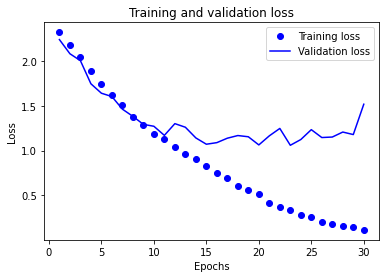

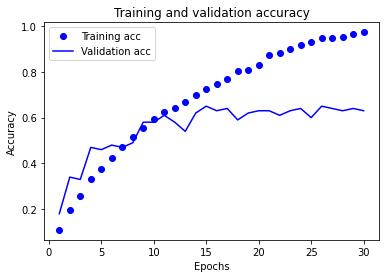

In [ ]:
# def fit_model(model, x, y, train_steps, epochs, validation_data, validation_steps, model_path):
my_model = build_my_model() 

train_data = get_train_data_generator()
val_data = get_validation_data_generator()

train_steps = train_data.samples / train_data.batch_size
val_steps = val_data.samples / val_data.batch_size

my_model_path = "/content/drive/MyDrive/GTZAN/models/my_network"

EPOCHS = 30

fit_model(
    model=my_model, 
    x=train_data, 
    y=None,
    train_steps=train_steps,
    epochs=EPOCHS,
    validation_data=val_data,
    validation_steps=val_steps,
    model_path=my_model_path
)

### Evaluate

In [ ]:
# def evaluate_model(train_x, train_y, val_x, val_y):

evaluate_model(
    model=my_model,
    train_x=train_data, 
    train_y=None, 
    val_x=val_data, 
    val_y=None
)

Train loss: 0.0475
Train accuracy: 0.9906
Validation loss: 1.5193
Validation accuracy: 0.63


### Predict

In [ ]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

test_dir = gtzan_test_dir
test_datagen = ImageDataGenerator(rescale=1./255)

# shuffle=False in order to preserve the order of filenames and predictions.
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=image_target_size,
    color_mode="rgba",
    class_mode=None,
    shuffle=False,
    seed=42
)

predictions = my_model.predict(
    test_generator,
)

predicted_class_indices=np.argmax(predictions,axis=1)
labels = genres
# labels = train_data.class_indices
# labels = dict((v,k) for k,v in labels.items())
prediction_results = [labels[k] for k in predicted_class_indices]

filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames,
                      "Predictions": prediction_results})
print(results)

Found 49 images belonging to 1 classes.
2/2 [==============================] - 2s 495ms/step
                     Filename Predictions
0       images/blues00005.png   classical
1       images/blues00010.png   classical
2       images/blues00049.png       blues
3       images/blues00060.png       blues
4       images/blues00096.png     country
5   images/classical00020.png   classical
6   images/classical00033.png   classical
7   images/classical00053.png   classical
8   images/classical00066.png   classical
9   images/classical00076.png   classical
10    images/country00036.png       disco
11    images/country00044.png     country
12    images/country00056.png     country
13    images/country00057.png     country
14    images/country00067.png       blues
15      images/disco00007.png       disco
16      images/disco00047.png   classical
17      images/disco00048.png       disco
18      images/disco00062.png       disco
19      images/disco00085.png      hiphop
20     images/hiphop00018

Confusion Matrix
[[2 2 1 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [1 0 3 1 0 0 0 0 0 0]
 [0 1 0 3 1 0 0 0 0 0]
 [0 0 0 1 3 0 0 1 0 0]
 [0 0 2 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 1 1 0 0 0 2 1 0]
 [1 0 0 0 1 0 0 0 3 0]
 [0 1 1 1 0 0 1 0 0 1]]
Classification Report
              precision    recall  f1-score   support

       blues       0.50      0.40      0.44         5
   classical       0.56      1.00      0.71         5
     country       0.38      0.60      0.46         5
       disco       0.43      0.60      0.50         5
      hiphop       0.60      0.60      0.60         5
        jazz       1.00      0.50      0.67         4
       metal       0.83      1.00      0.91         5
         pop       0.67      0.40      0.50         5
      reggae       0.75      0.60      0.67         5
        rock       1.00      0.20      0.33         5

    accuracy                           0.59        49
   macro avg       0.67      0.59      0.58        49
weighted avg       0.66   

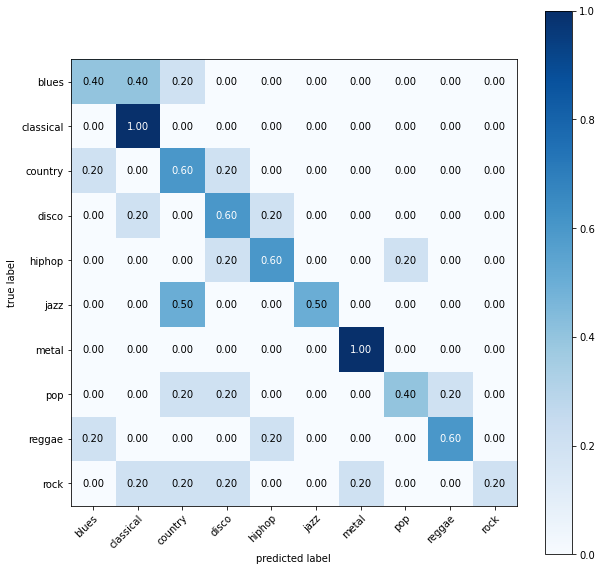

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
import re


classes = sorted([
    genres.index(re.sub(r'\d', '', c.replace(".png", ""))) 
    for c in os.listdir(test_dir + "/images/")
])
y_pred = np.argmax(predictions, axis=1)

print('Confusion Matrix')
con_mat = confusion_matrix(classes, y_pred)

fig, ax = plot_confusion_matrix(
    conf_mat=con_mat,
    colorbar=True,
    show_absolute=False,
    show_normed=True,
    figsize=(10, 10),
    class_names=genres
)

print(confusion_matrix(classes, y_pred))
print('Classification Report')
target_names = genres
print(classification_report(classes, y_pred, target_names=target_names))
print("Cohen's Kappa: {}".format(cohen_kappa_score(classes, y_pred)))
print("Accuracy: ",accuracy_score(classes, y_pred))

## Pretrained models

In [12]:
from functools import reduce

def get_f_map_dims(shape):
  return reduce((lambda x, y: x * y), list(shape)) 


def get_file_paths_recursive(root_dir: str) -> List[str]:
  src_file_paths = []
  for genre in genres:
    for file_path in glob.glob(os.path.join(root_dir, f"{genre}", "*.png"), recursive=True):
        src_file_paths.append(file_path)
  
  return src_file_paths

In [47]:
from typing import List
from keras.applications import VGG16, Xception, ResNet50V2, InceptionV3

input_shape = (*image_target_size, 3)

params = {
    "weights": "imagenet", 
    "include_top": False, 
    "input_shape": input_shape
}

final_feature_map_shape = None
saved_model_dir = "/content/drive/MyDrive/GTZAN/models/"

def get_conv_base(base: str, base_path: str):
  if base == "v":
    shape = (9, 13, 512)
    base_path += "VGG16/"
    conv_base = VGG16(**params)
  elif base == "x":
    shape = (9, 14, 2048)
    base_path += "Xception/"
    conv_base = Xception(**params)
  elif base == "r":
    shape = (9, 14, 2048)
    base_path += "ResNet50V2/"
    conv_base = ResNet50V2(**params)
  elif base == "i":
    shape = (7, 12, 2048)
    base_path += "InceptionV3/"
    conv_base = InceptionV3(**params)
  
  return conv_base, shape, base_path


# weights specifies the weight checkpoint from which to initialize the model.
# 
# include_top refers to including (or not) the densely connected
# classifier on top of the network. By default, this densely connected
# classifier corresponds to the 1,000 classes from ImageNet.
# 
# input_shape is the shape of the image tensors that you’ll feed to the
# network. 
conv_base, final_feature_map_shape, saved_model_dir = get_conv_base("r", saved_model_dir)

conv_base.summary()

94668760/94668760 [==============================] - 5s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 288, 432, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 294, 438, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 144, 216, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

### Feature Extraction without Data Augmentation 

#### Data generators

In [48]:
import os
import numpy as np
from typing import Set
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
WITHOUT_DA_BATCH_SIZE = 20

flatten_feature_map = get_f_map_dims(final_feature_map_shape)

# This function is extracting features on VGG16 convolutional base and returns (features, labels).
def extract_features(directory: str, sample_count: int):
  classes_count = len(genres)
  features = np.zeros(shape=(sample_count, *final_feature_map_shape))
  labels = np.zeros(shape=(sample_count, classes_count))
  
  generator = datagen.flow_from_directory(
      directory,
      target_size=image_target_size,
      batch_size=WITHOUT_DA_BATCH_SIZE,
      class_mode='categorical'
  )
  
  print("Extracting features on pretrained convolutional base...")
  i = 0
  for inputs_batch, labels_batch in generator:
    start = i * WITHOUT_DA_BATCH_SIZE
    end = (i + 1) * WITHOUT_DA_BATCH_SIZE

    print()
    features_batch = conv_base.predict(inputs_batch, verbose=2)
    print(f"{end} images predicted")

    features[start : end] = features_batch
    labels[start : end] = labels_batch
    i += 1
    if i * WITHOUT_DA_BATCH_SIZE >= sample_count:
      break
  
  return features, labels


def get_train_data_without_da():
  print("Creating train features and labels")

  images_path = gtzan_train_dir
  src_file_paths = get_file_paths_recursive(images_path)

  train_files_count = len(src_file_paths)

  train_features, train_labels = extract_features(images_path, train_files_count)
  train_features = np.reshape(train_features, (train_files_count, flatten_feature_map))

  return train_features, train_labels

def get_validation_data_without_da():
  print("Creating validation features and labels")

  images_path = gtzan_val_dir
  src_file_paths = get_file_paths_recursive(images_path)

  val_files_count = len(src_file_paths)
  
  validation_features, validation_labels = extract_features(images_path, val_files_count)
  validation_features = np.reshape(validation_features, (val_files_count, flatten_feature_map))

  return validation_features, validation_labels

def get_test_data_generator():
  print("Creating test data generator")

  images_path = gtzan_test_dir
  src_file_paths = get_file_paths_recursive(images_path)

  test_files_count = len(src_file_paths)
  
  test_features, test_labels = extract_features(images_path, test_files_count)
  test_features = np.reshape(test_features, (test_files_count, flatten_feature_map))

  return test_features

#### Model

In [49]:
def build_model_without_da() -> Sequential:
  
  model = models.Sequential()

  model.add(layers.Dense(512, activation='relu', input_dim=flatten_feature_map))
  model.add(layers.Dropout(0.5))

  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.3))

  model.add(layers.Dense(10, activation='softmax'))
  
  model.compile(
      optimizer=optimizers.RMSprop(lr=2e-5),
      loss=losses.categorical_crossentropy,
      metrics=[metrics.categorical_accuracy]
  )

  return model

#### Fit

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Creating train features and labels
Found 850 images belonging to 10 classes.
Extracting features on pretrained convolutional base...

1/1 - 3s - 3s/epoch - 3s/step
20 images predicted

1/1 - 0s - 47ms/epoch - 47ms/step
40 images predicted

1/1 - 0s - 48ms/epoch - 48ms/step
60 images predicted

1/1 - 0s - 43ms/epoch - 43ms/step
80 images predicted

1/1 - 0s - 33ms/epoch - 33ms/step
100 images predicted

1/1 - 0s - 49ms/epoch - 49ms/step
120 images predicted

1/1 - 0s - 32ms/epoch - 32ms/step
140 images predicted

1/1 - 0s - 48ms/epoch - 48ms/step
160 images predicted

1/1 - 0s - 36ms/epoch - 36ms/step
180 images predicted

1/1 - 0s - 46ms/epoch - 46ms/step
200 images predicted

1/1 - 0s - 33ms/epoch - 33ms/step
220 images predicted

1/1 - 0s - 32ms/epoch - 32ms/step
240 images predicted

1/1 - 0s - 32ms/epoch - 32ms/step
260 images predicted

1/1 - 0s - 32ms/epoch - 32ms/step
280 images predicted

1/1 - 0s - 33ms/epoch - 33ms/step
300 images predicted

1/1 - 0s - 32ms/epoch - 32ms/step


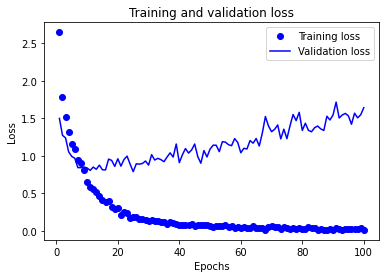

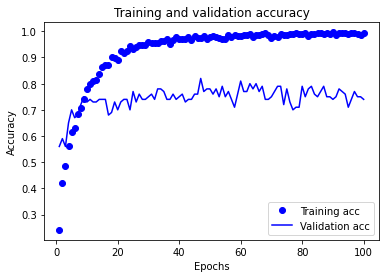

In [50]:
# def fit_model(model, x, y, train_steps, epochs, validation_data, validation_steps, model_path):
model_without_da = build_model_without_da() 

train_features, train_labels = get_train_data_without_da()
val_data = get_validation_data_without_da()

train_images_count = len(get_file_paths_recursive(gtzan_train_dir))
val_images_count = len(get_file_paths_recursive(gtzan_val_dir))

train_steps = train_images_count / WITHOUT_DA_BATCH_SIZE
val_steps = val_images_count / WITHOUT_DA_BATCH_SIZE

model_without_da_path = saved_model_dir + "feature_extraction/without_data_augmentation.h5"

EPOCHS = 100

fit_model(
    model=model_without_da, 
    x=train_features, 
    y=train_labels,
    train_steps=train_steps,
    epochs=EPOCHS,
    validation_data=val_data,
    validation_steps=val_steps,
    model_path=model_without_da_path
)

#### Evaluate

In [51]:
# def evaluate_model(train_x, train_y, val_x, val_y):

evaluate_model(
    model=model_without_da,
    train_x=train_features, 
    train_y=train_labels, 
    val_x=val_data[0], 
    val_y=val_data[1]
)

Train loss: 0.0
Train accuracy: 1.0
Validation loss: 1.6424
Validation accuracy: 0.74


#### Predict

### Feature Extraction with Data Augmentation

#### Data generators

In [52]:
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

# BATCH_SIZE = 128
WITH_DA_BATCH_SIZE = 20
target_size = image_target_size

def get_train_data_generator_with_da() -> DirectoryIterator:
  print("Creating train data generator")

  train_dir = train_dir_on_colab_instance
  
  train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
  )

  train_generator = train_datagen.flow_from_directory(
      train_dir, 
      target_size=target_size, 
      batch_size=WITH_DA_BATCH_SIZE, 
      class_mode="categorical"
  )

  return train_generator


def get_validation_data_generator_with_da() -> DirectoryIterator:
  print("Creating validation data generator")
  validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

  validation_dir = val_dir_on_colab_instance

  validation_generator = validation_datagen.flow_from_directory(
      validation_dir, 
      target_size=target_size, 
      batch_size=WITH_DA_BATCH_SIZE, 
      class_mode="categorical",  
      shuffle = False
  )
  return validation_generator

#### Model

In [53]:
def build_model_with_da() -> Sequential:
  
  model = models.Sequential()

  model.add(conv_base)

  model.add(layers.Flatten())

  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.5))

  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.3))

  model.add(layers.Dense(10, activation='softmax'))
  
  model.compile(
      optimizer=optimizers.RMSprop(lr=2e-5),
      loss=losses.categorical_crossentropy,
      metrics=[metrics.categorical_accuracy]
  )

  return model

#### Fit

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Creating train data generator
Found 850 images belonging to 10 classes.
Creating validation data generator
Found 100 images belonging to 10 classes.
Epoch 1/60
42/42 [==============================] - 40s 723ms/step - loss: 3.2049 - categorical_accuracy: 0.1106 - val_loss: 2.2010 - val_categorical_accuracy: 0.1800
Epoch 2/60
42/42 [==============================] - 31s 716ms/step - loss: 2.4955 - categorical_accuracy: 0.1812 - val_loss: 2.0349 - val_categorical_accuracy: 0.2700
Epoch 3/60
42/42 [==============================] - 30s 704ms/step - loss: 2.3219 - categorical_accuracy: 0.2200 - val_loss: 1.8545 - val_categorical_accuracy: 0.4300
Epoch 4/60
42/42 [==============================] - 30s 704ms/step - loss: 2.2135 - categorical_accuracy: 0.2376 - val_loss: 1.7404 - val_categorical_accuracy: 0.4500
Epoch 5/60
42/42 [==============================] - 30s 707ms/step - loss: 2.0879 - categorical_accuracy: 0.2718 - val_loss: 1.6538 - val_categorical_accuracy: 0.4300
Epoch 6/60
42/42

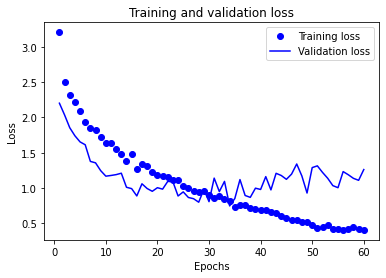

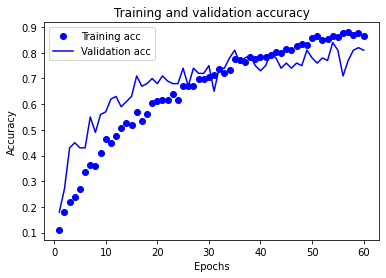

In [57]:
# def fit_model(model, x, y, train_steps, epochs, validation_data, validation_steps, model_path):
model_with_da = build_model_with_da() 

train_data = get_train_data_generator_with_da()
val_data = get_validation_data_generator_with_da()

train_steps = train_data.samples / train_data.batch_size
val_steps = val_data.samples / val_data.batch_size

model_with_da_path = saved_model_dir + "feature_extraction/with_data_augmentation.h5"

EPOCHS = 80

fit_model(
    model=model_with_da, 
    x=train_data, 
    y=None,
    train_steps=train_steps,
    epochs=EPOCHS,
    validation_data=val_data,
    validation_steps=val_steps,
    model_path=model_with_da_path
)

#### Evaluate

In [ ]:
# def evaluate_model(train_x, train_y, val_x, val_y):

evaluate_model(
    model=model_with_da,
    train_x=train_data, 
    train_y=None, 
    val_x=val_data, 
    val_y=None
)

#### Predict

In [ ]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

test_dir = gtzan_test_dir
test_datagen = ImageDataGenerator(rescale=1./255)

# shuffle=False in order to preserve the order of filenames and predictions.
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=image_target_size,
    color_mode="rgb",
    class_mode=None,
    shuffle=False,
    seed=42
)

predictions = model_with_da.predict(
    test_generator,
)

predicted_class_indices=np.argmax(predictions,axis=1)
labels = genres
# labels = train_data.class_indices
# labels = dict((v,k) for k,v in labels.items())
prediction_results = [labels[k] for k in predicted_class_indices]

filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames,
                      "Predictions": prediction_results})
print(results)

Confusion Matrix
[[4 0 0 0 0 0 0 1 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 1 0 0 0 1]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 3 0 1 0 1 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [1 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 1 4 0]
 [0 1 0 0 0 0 0 1 0 3]]
Classification Report
              precision    recall  f1-score   support

       blues       0.80      0.80      0.80         5
   classical       0.83      1.00      0.91         5
     country       1.00      0.60      0.75         5
       disco       1.00      1.00      1.00         5
      hiphop       1.00      0.60      0.75         5
        jazz       0.80      1.00      0.89         4
       metal       0.83      1.00      0.91         5
         pop       0.57      0.80      0.67         5
      reggae       0.80      0.80      0.80         5
        rock       0.75      0.60      0.67         5

    accuracy                           0.82        49
   macro avg       0.84      0.82      0.81        49
weighted avg       0.84   

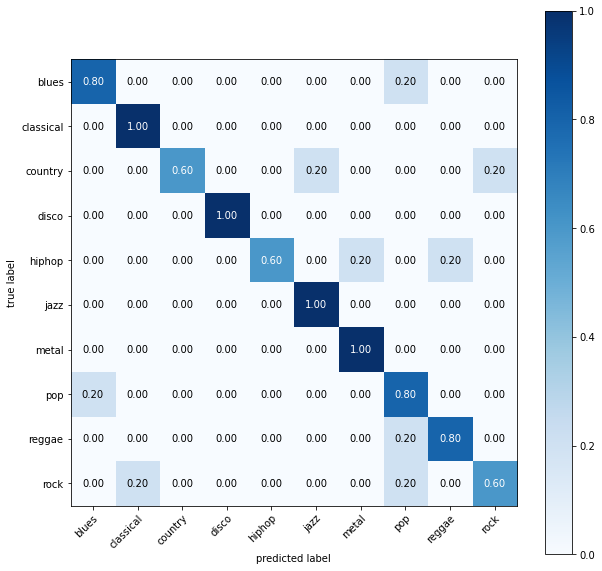

In [36]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
import re


classes = sorted([
    genres.index(re.sub(r'\d', '', c.replace(".png", ""))) 
    for c in os.listdir(test_dir + "/images/")
])
y_pred = np.argmax(predictions, axis=1)

print('Confusion Matrix')
con_mat = confusion_matrix(classes, y_pred)

fig, ax = plot_confusion_matrix(
    conf_mat=con_mat,
    colorbar=True,
    show_absolute=False,
    show_normed=True,
    figsize=(10, 10),
    class_names=genres
)

print(confusion_matrix(classes, y_pred))
print('Classification Report')
target_names = genres
print(classification_report(classes, y_pred, target_names=target_names))
print("Cohen's Kappa: {}".format(cohen_kappa_score(classes, y_pred)))
print("Accuracy: ",accuracy_score(classes, y_pred))

### Fine Tuning

#### Data generators

In [37]:
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

# BATCH_SIZE = 128
FINE_TUNING_BATCH_SIZE = 20

flatten_feature_map = get_f_map_dims(final_feature_map_shape)

def get_train_data_generator_fine_tuning() -> DirectoryIterator:
  print("Creating train data generator")

  train_dir = train_dir_on_colab_instance
  target_size = image_target_size
  
  train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
  )

  train_generator = train_datagen.flow_from_directory(
      train_dir, 
      target_size=target_size, 
      batch_size=FINE_TUNING_BATCH_SIZE, 
      class_mode="categorical"
  )

  return train_generator


def get_validation_data_generator_fine_tuning() -> DirectoryIterator:
  print("Creating validation data generator")
  validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

  validation_dir = val_dir_on_colab_instance
  target_size = image_target_size

  validation_generator = validation_datagen.flow_from_directory(
      validation_dir, 
      target_size=target_size, 
      batch_size=FINE_TUNING_BATCH_SIZE, 
      class_mode="categorical",  
      shuffle = False
  )
  return validation_generator

#### Model

In [38]:
def build_model_fine_tuning() -> Sequential:
  
  conv_base_fine_tuning = conv_base
  conv_base_fine_tuning.trainable = True

  set_trainable = False
  for layer in conv_base_fine_tuning.layers:
    if layer.name == 'block5_conv1':
      set_trainable = True
    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False

  
  model = models.Sequential()

  model.add(conv_base_fine_tuning)

  model.add(layers.Flatten())

  model.add(layers.Dense(512, activation='relu', input_dim=flatten_feature_map))
  model.add(layers.Dropout(0.5))

  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.3))

  model.add(layers.Dense(10, activation='softmax'))
  
  model.compile(
      optimizer=optimizers.RMSprop(lr=1e-5),
      loss=losses.categorical_crossentropy,
      metrics=[metrics.categorical_accuracy]
  )

  return model

#### Fit

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Creating train data generator
Found 850 images belonging to 10 classes.
Creating validation data generator
Found 100 images belonging to 10 classes.
Epoch 1/150
42/42 [==============================] - 30s 643ms/step - loss: 1.9143 - categorical_accuracy: 0.5235 - val_loss: 1.5299 - val_categorical_accuracy: 0.7100
Epoch 2/150
42/42 [==============================] - 27s 625ms/step - loss: 1.2226 - categorical_accuracy: 0.8647 - val_loss: 1.0827 - val_categorical_accuracy: 0.7800
Epoch 3/150
42/42 [==============================] - 27s 627ms/step - loss: 0.7981 - categorical_accuracy: 0.9235 - val_loss: 0.8691 - val_categorical_accuracy: 0.7500
Epoch 4/150
42/42 [==============================] - 27s 628ms/step - loss: 0.5584 - categorical_accuracy: 0.9447 - val_loss: 0.7834 - val_categorical_accuracy: 0.7600
Epoch 5/150
42/42 [==============================] - 27s 630ms/step - loss: 0.4120 - categorical_accuracy: 0.9541 - val_loss: 0.7529 - val_categorical_accuracy: 0.7600
Epoch 6/150

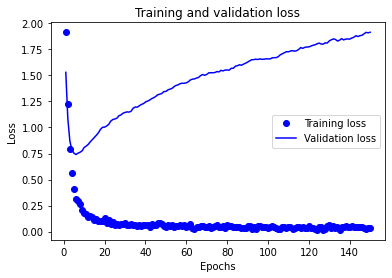

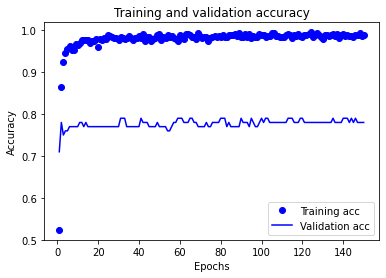

In [39]:
# def fit_model(model, x, y, train_steps, epochs, validation_data, validation_steps, model_path):
model_fine_tuning = build_model_fine_tuning() 

train_data = get_train_data_generator_fine_tuning()
val_data = get_validation_data_generator_fine_tuning()

train_steps = train_data.samples / train_data.batch_size
val_steps = val_data.samples / val_data.batch_size

model_with_fine_tuning_path = saved_model_dir +  "fine_tuning.h5"

EPOCHS = 150

fit_model(
    model=model_fine_tuning, 
    x=train_data, 
    y=None,
    train_steps=train_steps,
    epochs=EPOCHS,
    validation_data=val_data,
    validation_steps=val_steps,
    model_path=model_with_fine_tuning_path
)

#### Evaluate

In [40]:
# def evaluate_model(train_x, train_y, val_x, val_y):

evaluate_model(
    model=model_fine_tuning,
    train_x=train_data, 
    train_y=None, 
    val_x=val_data, 
    val_y=None
)

Train loss: 0.0267
Train accuracy: 0.9906
Validation loss: 1.9151
Validation accuracy: 0.78


#### Predict

In [41]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

test_dir = gtzan_test_dir
test_datagen = ImageDataGenerator(rescale=1./255)

# shuffle=False in order to preserve the order of filenames and predictions.
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=image_target_size,
    color_mode="rgb",
    class_mode=None,
    shuffle=False,
    seed=42
)

predictions = model_fine_tuning.predict(
    test_generator,
)

predicted_class_indices=np.argmax(predictions,axis=1)
labels = genres
# labels = train_data.class_indices
# labels = dict((v,k) for k,v in labels.items())
prediction_results = [labels[k] for k in predicted_class_indices]

filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames,
                      "Predictions": prediction_results})
print(results)

Found 49 images belonging to 1 classes.
2/2 [==============================] - 1s 361ms/step
                     Filename Predictions
0       images/blues00004.png       blues
1       images/blues00005.png       blues
2       images/blues00044.png       blues
3       images/blues00072.png         pop
4       images/blues00077.png       blues
5   images/classical00008.png   classical
6   images/classical00068.png   classical
7   images/classical00078.png   classical
8   images/classical00083.png   classical
9   images/classical00092.png   classical
10    images/country00052.png     country
11    images/country00056.png     country
12    images/country00067.png     country
13    images/country00093.png        jazz
14    images/country00099.png        rock
15      images/disco00054.png       disco
16      images/disco00056.png       disco
17      images/disco00084.png       disco
18      images/disco00097.png       disco
19      images/disco00099.png       disco
20     images/hiphop00006

Confusion Matrix
[[4 0 0 0 0 0 0 1 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 1 0 0 0 1]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 3 0 1 0 1 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [1 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 1 4 0]
 [0 1 1 0 0 0 0 1 0 2]]
Classification Report
              precision    recall  f1-score   support

       blues       0.80      0.80      0.80         5
   classical       0.83      1.00      0.91         5
     country       0.75      0.60      0.67         5
       disco       1.00      1.00      1.00         5
      hiphop       1.00      0.60      0.75         5
        jazz       0.80      1.00      0.89         4
       metal       0.83      1.00      0.91         5
         pop       0.57      0.80      0.67         5
      reggae       0.80      0.80      0.80         5
        rock       0.67      0.40      0.50         5

    accuracy                           0.80        49
   macro avg       0.81      0.80      0.79        49
weighted avg       0.81   

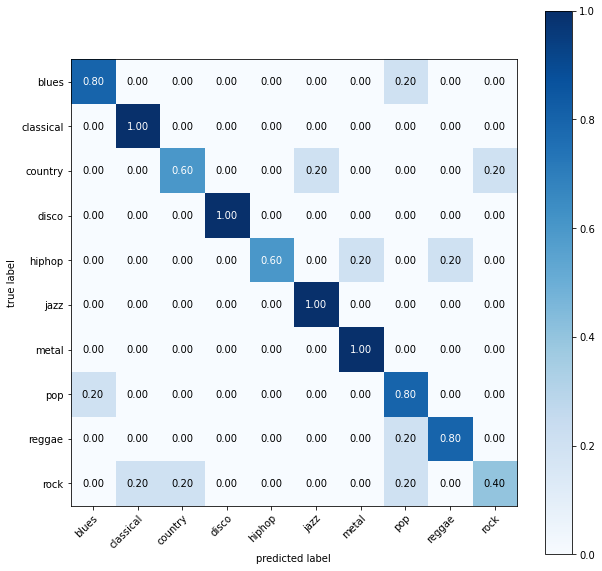

In [42]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
import re


classes = sorted([
    genres.index(re.sub(r'\d', '', c.replace(".png", ""))) 
    for c in os.listdir(test_dir + "/images/")
])
y_pred = np.argmax(predictions, axis=1)

print('Confusion Matrix')
con_mat = confusion_matrix(classes, y_pred)

fig, ax = plot_confusion_matrix(
    conf_mat=con_mat,
    colorbar=True,
    show_absolute=False,
    show_normed=True,
    figsize=(10, 10),
    class_names=genres
)

print(confusion_matrix(classes, y_pred))
print('Classification Report')
target_names = genres
print(classification_report(classes, y_pred, target_names=target_names))
print("Cohen's Kappa: {}".format(cohen_kappa_score(classes, y_pred)))
print("Accuracy: ",accuracy_score(classes, y_pred))

# Results

### My network
#### Results on 3 sec spectograms: 
- Train loss: 0.0192
- Train accuracy: 0.9945
- Validation loss: 0.8952
- Validation accuracy: 0.7120

#### Results on provided spectograms: 
- Train loss: 0.0982
- Train accuracy: 0.9765
- Validation loss: 1.0701
- Validation accuracy: 0.64


### VGG16
#### Feature extraction without Data Augmentation
- Train loss: 0.1399
- Train accuracy: 0.9741
- Validation loss: 1.0701
- Validation accuracy: 0.74

#### Feature extraction with Data Augmentation
- Train loss: 0.1468
- Train accuracy: 0.9718
- Validation loss: 0.8646
- Validation accuracy: 0.76

#### Feature extraction with Fine Tuning
- Train loss: 0.336
- Train accuracy: 0.8894
- Validation loss: 1.1155
- Validation accuracy: 0.69



### Xception
#### Feature extraction without Data Augmentation
- Train loss: 0.0008
- Train accuracy: 1.0
- Validation loss: 1.2818
- Validation accuracy: 0.73

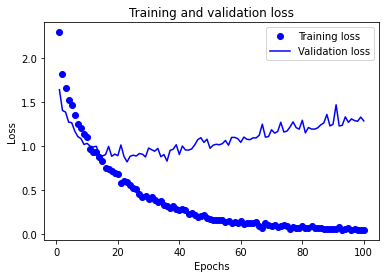

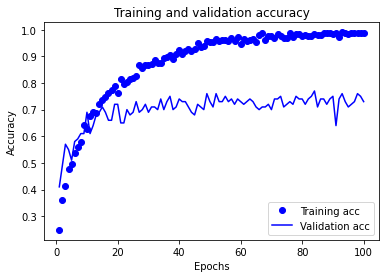



#### Feature extraction with Data Augmentation
- Train loss: 0.0437
- Train accuracy: 0.9835
- Validation loss: 1.5452
- Validation accuracy: 0.76

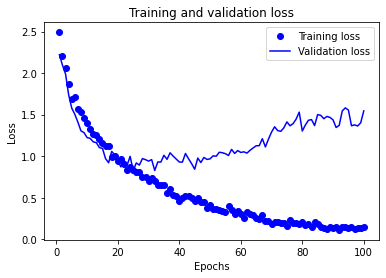


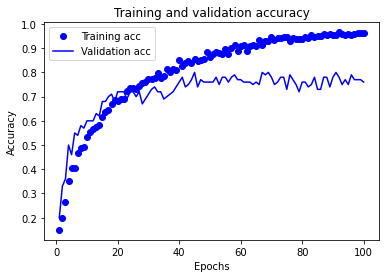


Classification Report
```
              precision    recall  f1-score   support

       blues       0.80      0.80      0.80         5
   classical       0.83      1.00      0.91         5
     country       1.00      0.60      0.75         5
       disco       1.00      1.00      1.00         5
      hiphop       1.00      0.60      0.75         5
        jazz       0.80      1.00      0.89         4
       metal       0.83      1.00      0.91         5
         pop       0.57      0.80      0.67         5
      reggae       0.80      0.80      0.80         5
        rock       0.75      0.60      0.67         5

    accuracy                           0.82        49
   macro avg       0.84      0.82      0.81        49
weighted avg       0.84      0.82      0.81        49


Cohen's Kappa: 0.7959278111985193
Accuracy:  0.8163265306122449
```


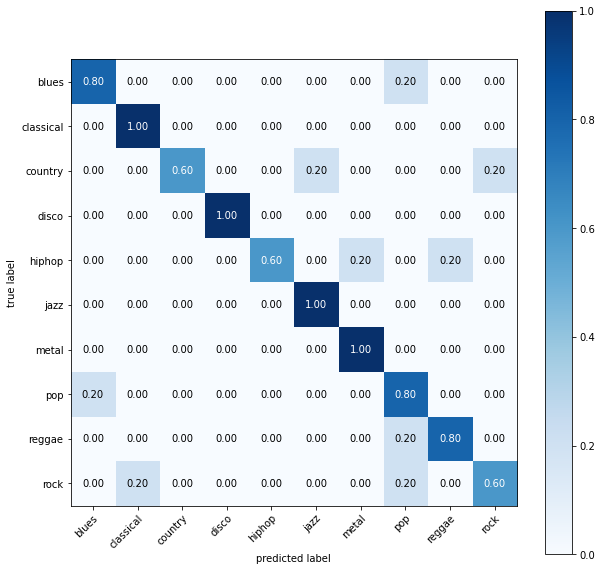

#### Feature extraction with Fine Tuning

- Train loss: 0.0267
- Train accuracy: 0.9906
- Validation loss: 1.9151
- Validation accuracy: 0.78


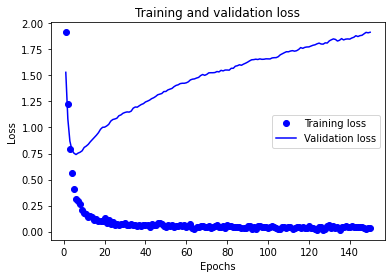


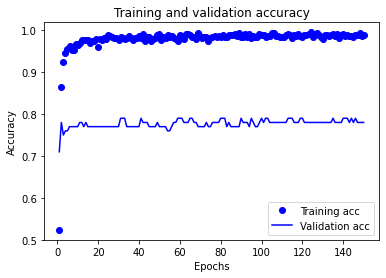

```
Classification Report
              precision    recall  f1-score   support

       blues       0.80      0.80      0.80         5
   classical       0.83      1.00      0.91         5
     country       0.75      0.60      0.67         5
       disco       1.00      1.00      1.00         5
      hiphop       1.00      0.60      0.75         5
        jazz       0.80      1.00      0.89         4
       metal       0.83      1.00      0.91         5
         pop       0.57      0.80      0.67         5
      reggae       0.80      0.80      0.80         5
        rock       0.67      0.40      0.50         5

    accuracy                           0.80        49
   macro avg       0.81      0.80      0.79        49
weighted avg       0.81      0.80      0.79        49

Cohen's Kappa: 0.7732531235539103
Accuracy:  0.7959183673469388
```
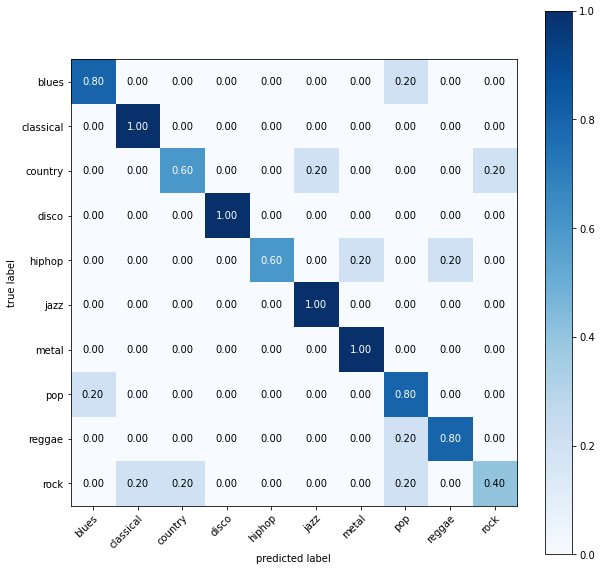


### ResNet50V2

#### Feature extraction without Data Augmentation

- Train loss: 0.0
- Train accuracy: 1.0
- Validation loss: 1.6424
- Validation accuracy: 0.74

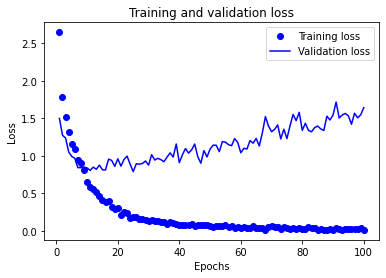

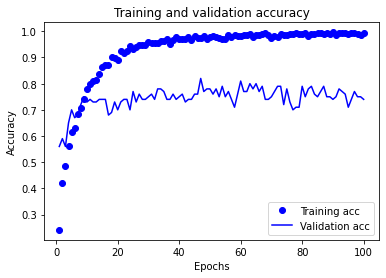

#### Feature extraction with Data Augmentation

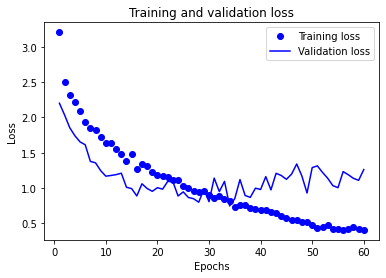

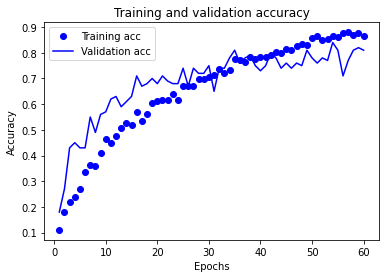

#### Feature extraction with Fine Tuning


### InceptionV3